# 데이터 전처리 방안 수정
- TF-IDF 관련 `n_components`실험
- 최초 기본이 되는 데이터 프레임 그리드 생성시 타겟값의 범위를 (0, 20)으로 클리핑
- 데이터 누수가 일어날 수 있는 파생변수들에 대한 코드 수정
    - add_lag_features 함수 수정
    - lag 변수 결측치 처리 : 판매량과 관련한 피처들은 0으로 채우되, 이외의 피처(가격)는 nan으로 두고 처리하지 않음
    - delta 함수 생성 로직 변경
    - new_item, item_age에 대한 수정
    - item_cnt_month_lag2, item_cnt_month_lag_3 추가
- city에 대한 전처리 수정
- rolling window 피처 생성
- 아이템의 상품 신규 입점 : new_item_last_month, new_on_shelf_last_month item_shop_age
- lag_12 피처를 위해 초기 12개월 데이터 제거

# Module

In [1]:
import gc
import calendar
import re
from itertools import product
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

%matplotlib inline
plt.style.use("seaborn-v0_8-white")

# Data

In [2]:
data_path = "./data/"

sales_train = pd.read_csv(data_path + 'sales_train.csv')
items = pd.read_csv(data_path + 'items.csv')
item_categories = pd.read_csv(data_path + 'item_categories.csv')
shops = pd.read_csv(data_path + 'shops.csv')

test = pd.read_csv(data_path + 'test.csv')
sub = pd.read_csv(data_path + 'sample_submission.csv')

print('Before Filter ShopID:', len(sales_train))
unique_test_shop_id = test['shop_id'].unique()
sales_train = sales_train[sales_train['shop_id'].isin(unique_test_shop_id)]
print('After Filter ShopID :', len(sales_train))

Before Filter ShopID: 2935849
After Filter ShopID : 2413246


In [3]:
# def downcast(df, include_floats=None, verbose=True):
#     start_memory = df.memory_usage().sum() / 1024**2
    
#     if include_floats is None:
#         include_floats = []

#     for col in df.columns:
#         dtype_name = df[col].dtype.name
        
#         if dtype_name == 'object':
#             pass
            
#         elif dtype_name == 'bool':
#             df[col] = df[col].astype('int8')
            
#         elif dtype_name.startswith('int') or (df[col]%1==0).all():
#             df[col] = pd.to_numeric(df[col], downcast='integer')
            
#         elif dtype_name.startswith('float'):
#             if col in include_floats:
#                 df[col] = pd.to_numeric(df[col], downcast='float')

#     end_memory = df.memory_usage().sum() / 1024**2
#     if verbose:
#         print(f"Memory usage reduced from {start_memory:.2f} MB to {end_memory:.2f} MB")
        
#     return df

In [4]:
def downcast(df, verbose=True):
    start_memory = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col]%1==0).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        elif dtype_name.startswith('float'):
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_memory = df.memory_usage().sum() / 1024**2
    
    if verbose:
        print(f"Memory usage reduced from {start_memory:.2f} MB to {end_memory:.2f} MB")
        
    return df

In [5]:
train = []

for i in sales_train['date_block_num'].unique():
    all_shop = sales_train.loc[sales_train['date_block_num'] == i, 'shop_id'].unique()
    all_item = sales_train.loc[sales_train['date_block_num'] == i, 'item_id'].unique()
    train.append(np.array(list(product([i], all_shop, all_item))))

# idx features        
idx_features = ['date_block_num', 'shop_id', 'item_id']
train = pd.DataFrame(np.vstack(train), columns=idx_features)

test['date_block_num'] = 34
train.head()

,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564


# Feature Engineering

## Outliers
- `-1` 같은 음수값은 반품을 의미할 수 있음. 제거하지 않고 `item_cnt_month`로 집계

In [6]:
print("Before : ",len(sales_train))
sales_train = sales_train[sales_train['item_cnt_day'] < 1000]
print("After item_cnt_day : ",len(sales_train))
sales_train = sales_train[sales_train['item_price'] < 50000]
print("After item_price : ",len(sales_train))

Before :  2413246
After item_cnt_day :  2413244
After item_price :  2413241


## Define function

In [7]:
def add_mean_features(df: pd.DataFrame, groupby_features: list, mean_feature_list: list = None):
    col_name = [col for col in groupby_features if col != 'date_block_num']
    base_name = '_'.join([col.replace('_id', '') for col in col_name])
    feature_name = f'{base_name}_avg_date_sales'
    
    agg_rules = {
        feature_name: ('item_cnt_month', 'mean')
    }
    
    group = df.groupby(groupby_features).agg(**agg_rules).reset_index()
    
    df = df.merge(group, on=groupby_features, how='left')
    del group
    
    if mean_feature_list is not None:
        mean_feature_list.append(feature_name)
    
    return df


def add_lag_features(df: pd.DataFrame, key_features: list, lag_feature_cols: list, lag_period: list):
    df_result = df.copy()

    for i in lag_period:
        df_lag = df[key_features + lag_feature_cols].copy()
        
        df_lag['date_block_num'] += i
        
        lag_col_names = {col: f'{col}_lag_{i}' for col in lag_feature_cols}
        df_lag = df_lag.rename(columns=lag_col_names)
        
        df_result = pd.merge(df_result, df_lag, on=key_features, how='left')

    all_lag_cols = [f'{col}_lag_{i}' for col in lag_feature_cols for i in lag_period]
    for col in all_lag_cols:
        if 'cnt' in col or 'sales' in col:
            df_result[col] = df_result[col].fillna(0)

    return df_result


def fill_price_nans(df):
    """
    1. delta 피처 -> 0으로 대체
    2. price(절대값) 피처 -> 해당 아이템의 전체 평균 가격 -> 카테고리 평균 가격 순으로 대체
    """
    # delta feature
    delta_cols = [col for col in df.columns if 'delta_price' in col]
    for col in delta_cols:
        df[col] = df[col].fillna(0)

    # price lag features
    price_cols = [col for col in df.columns if 'price' in col and 'delta' not in col]
    if len(price_cols) > 0:
        item_mean_price = df.groupby('item_id')['date_item_avg_price'].mean()
        cat_mean_price = df.groupby('item_category_id')['date_item_avg_price'].mean()

        for col in price_cols:
            nan_mask = df[col].isnull()
            if nan_mask.sum() > 0:
                df.loc[nan_mask, col] = df.loc[nan_mask, 'item_id'].map(item_mean_price)
                    
            nan_mask = df[col].isnull()
            if nan_mask.sum() > 0:
                df.loc[nan_mask, col] = df.loc[nan_mask, 'item_category_id'].map(cat_mean_price)

    return df

## shops

In [8]:
# 데이터 수정
sales_train.loc[sales_train['shop_id']==0, 'shop_id'] = 57
sales_train.loc[sales_train['shop_id']==1, 'shop_id'] = 58
sales_train.loc[sales_train['shop_id']==10, 'shop_id'] = 11
sales_train.loc[sales_train['shop_id']==39, 'shop_id'] = 40

test.loc[test['shop_id']==0, 'shop_id'] = 57
test.loc[test['shop_id']==1, 'shop_id'] = 58
test.loc[test['shop_id']==10, 'shop_id'] = 11
test.loc[test['shop_id']==39, 'shop_id'] = 40

shops['city'] = shops['shop_name'].str.split(' ').str[0]
shops.loc[shops['city'] == '!Якутск', 'city'] = 'Якутск'

# 특수 상점(온라인/이동식)을 별도 도시 'Special'로 분류
shops.loc[shops['city'].isin(['Выездная', 'Интернет-магазин']), 'city'] = 'Special'

# 약어 및 오표기 수정
shops.loc[shops['city'] == 'СПб', 'city'] = 'Санкт-Петербург'
shops.loc[shops['city'] == 'Н.Новгород', 'city'] = 'НижнийНовгород'
shops.loc[shops['city'] == 'РостовНаДону', 'city'] = 'Ростов-на-Дону'

# 모스크바 위성 도시 통합
moscow_satellite_cities = ['Жуковский', 'Мытищи', 'Химки', 'Чехов', 'Балашиха', 'Сергиев']
shops.loc[shops['city'].isin(moscow_satellite_cities), 'city'] = 'МоскваОбласть'

# 쇼핑몰/센터를 나타내는 러시아어 약어로 상점 구분
mall_keywords = ['ТЦ', 'ТРК', 'ТРЦ', 'MALL', 'Молл']
is_mall = shops['shop_name'].apply(lambda x: any(keyword in x for keyword in mall_keywords))

shops['shop_type'] = np.where(is_mall, 'Mall', 'Standalone')

for col in ['city', 'shop_type']:
    encoder = LabelEncoder()
    shops[col] = encoder.fit_transform(shops[col])

shops = shops.drop(columns=["shop_name"])

## items

In [9]:
first_sale_mon = sales_train.groupby('item_id').agg({'date_block_num': 'min'})['date_block_num']
items['first_sale_month'] = items['item_id'].map(first_sale_mon).fillna(34)

##### 월별 아이템 평균가격

In [10]:
date_item_avg_price = sales_train.groupby(['date_block_num', 'item_id']).agg(date_item_avg_price=('item_price', 'mean')).reset_index()

### TF-IDF

In [11]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

items = items.merge(item_categories, on='item_category_id', how='left')
items['item_full_name'] = items['item_category_name'] + ' ' + items['item_name']
items['clean_item_name'] = items['item_full_name'].apply(clean_text)

tfidf = TfidfVectorizer(max_features=1000)
item_name_tfidf = tfidf.fit_transform(items['clean_item_name'])

n_comp = 20
svd = TruncatedSVD(n_components=n_comp, random_state=2025)
item_name_svd = svd.fit_transform(item_name_tfidf.toarray())

svd_cols = [f'item_name_svd_{i}' for i in range(n_comp)]
item_name_svd_df = pd.DataFrame(item_name_svd, columns=svd_cols)
item_name_svd_df['item_id'] = items['item_id']

items = items.merge(item_name_svd_df, on='item_id', how='left')
items.head()

,item_name,item_id,item_category_id,first_sale_month,item_category_name,item_full_name,clean_item_name,item_name_svd_0,item_name_svd_1,item_name_svd_2,...,item_name_svd_10,item_name_svd_11,item_name_svd_12,item_name_svd_13,item_name_svd_14,item_name_svd_15,item_name_svd_16,item_name_svd_17,item_name_svd_18,item_name_svd_19
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,34.0,Кино - DVD,Кино - DVD ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) ...,кино dvd во власти наваждения пласт d,0.343956,-0.072842,-0.003275,...,-0.001110,-0.002210,-0.001803,0.000177,0.001900,-0.000262,0.001198,0.000887,-0.000388,-0.001200
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,15.0,Программы - Для дома и офиса (Цифра),Программы - Для дома и офиса (Цифра) !ABBYY Fi...,программы для дома и офиса цифра abbyy finere...,0.004050,0.000853,0.029947,...,0.204098,0.035920,0.267784,0.008613,-0.016817,-0.096697,0.014582,-0.022068,0.053093,0.025555
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,34.0,Кино - DVD,Кино - DVD ***В ЛУЧАХ СЛАВЫ (UNV) ...,кино dvd в лучах славы unv ...,0.927008,-0.195910,-0.009256,...,-0.004155,-0.007278,-0.006979,0.001087,0.001387,0.001394,-0.001082,0.001154,-0.001486,-0.000554
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,34.0,Кино - DVD,Кино - DVD ***ГОЛУБАЯ ВОЛНА (Univ) ...,кино dvd голубая волна univ ...,0.927008,-0.195910,-0.009256,...,-0.004155,-0.007278,-0.006979,0.001087,0.001387,0.001394,-0.001082,0.001154,-0.001486,-0.000554
4,***КОРОБКА (СТЕКЛО) D,4,40,34.0,Кино - DVD,Кино - DVD ***КОРОБКА (СТЕКЛО) ...,кино dvd коробка стекло d,0.355035,-0.075058,-0.003462,...,0.003782,-0.000817,0.012545,0.000217,-0.001406,-0.008786,0.001147,-0.000997,0.002054,0.000699


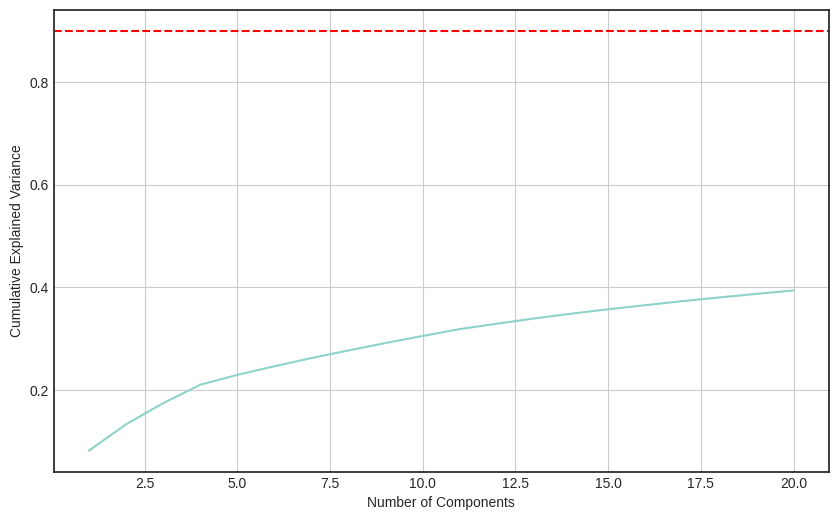

원본 데이터의 90%를 설명하기 위한 차원 수: 1


In [12]:
cumsum = np.cumsum(svd.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, len(cumsum) + 1), y=cumsum)
plt.grid(True)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.9, color='r', linestyle='--')
plt.show()

d = np.argmax(cumsum >= 0.9) + 1
print(f"원본 데이터의 90%를 설명하기 위한 차원 수: {d}")

In [13]:
items = items.drop(columns=['clean_item_name', 'item_name', 'item_full_name', 'item_category_name'])
gc.collect()

3299

## item_categories

In [14]:
def split_categories(df):
    def split_func(name):
        if '-' in name:
            return name.split('-', 1)
        else:
            return [name, name]
    
    split_result = df['item_category_name'].apply(lambda x: split_func(x))
    df['type'] = split_result.apply(lambda x: x[0].strip())
    df['subtype'] = split_result.apply(lambda x: x[1].strip())
    return df


item_categories = split_categories(item_categories)
etc_types = item_categories['type'].value_counts()[item_categories['type'].value_counts()<5].index.tolist()
item_categories.loc[item_categories['type'].isin(etc_types), 'type'] = 'etc'
item_categories['type'] = LabelEncoder().fit_transform(item_categories['type'])
item_categories['subtype'] = LabelEncoder().fit_transform(item_categories['subtype'])
item_categories = item_categories.drop('item_category_name', axis=1)

## revenue

In [15]:
sales_train['revenue'] = sales_train['item_cnt_day'] * sales_train['item_price']

## set up matrix

In [16]:
data_files = [sales_train, shops, items, item_categories]
for file in data_files:
    file = downcast(file)

Memory usage reduced from 147.29 MB to 87.45 MB
Memory usage reduced from 0.00 MB to 0.00 MB
Memory usage reduced from 3.89 MB to 1.78 MB
Memory usage reduced from 0.00 MB to 0.00 MB


In [17]:
group = sales_train.groupby(idx_features).agg(
    item_cnt_month = ('item_cnt_day', 'sum'),
    transaction_cnt = ('item_cnt_day', 'count'),
    date_revenue = ('revenue', 'sum')
).reset_index()

train = train.merge(group, on=idx_features, how='left')
all_data = pd.concat([train, test.drop('ID', axis=1)], ignore_index=True, keys=idx_features)
all_data = all_data.merge(shops, on='shop_id', how='left')
all_data = all_data.merge(items, on='item_id', how='left')
all_data = all_data.merge(date_item_avg_price, on=['date_block_num', 'item_id'], how='left')
all_data = all_data.merge(item_categories, on='item_category_id', how='left')
all_data.head()

/tmp/ipykernel_61402/101271298.py:8: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
  all_data = pd.concat([train, test.drop('ID', axis=1)], ignore_index=True, keys=idx_features)


,date_block_num,shop_id,item_id,item_cnt_month,transaction_cnt,date_revenue,city,shop_type,item_category_id,first_sale_month,...,item_name_svd_13,item_name_svd_14,item_name_svd_15,item_name_svd_16,item_name_svd_17,item_name_svd_18,item_name_svd_19,date_item_avg_price,type,subtype
0,0,59,22154,1.0,1.0,999.0,24,0,37,0,...,-0.003903,0.002876,-0.004709,-0.002156,-0.001261,-0.005914,0.000512,999.00,4,1
1,0,59,2552,NaN,NaN,NaN,24,0,58,0,...,0.036135,-0.016942,-0.046025,-0.003580,-0.034587,0.055813,-0.018581,899.00,6,29
2,0,59,2554,NaN,NaN,NaN,24,0,58,0,...,-0.018761,0.000624,-0.050743,0.006053,0.012731,-0.034054,-0.003083,1709.05,6,29
3,0,59,2555,NaN,NaN,NaN,24,0,56,0,...,0.037173,-0.010307,-0.039375,0.006050,-0.092118,0.291104,0.129827,1099.00,6,5
4,0,59,2564,NaN,NaN,NaN,24,0,59,0,...,0.004033,0.012936,0.024760,0.018163,-0.026524,0.166645,-0.001065,349.00,6,42


In [18]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8812244 entries, 0 to 8812243
Data columns (total 33 columns):
 #   Column               Dtype  
---  ------               -----  
 0   date_block_num       int64  
 1   shop_id              int64  
 2   item_id              int64  
 3   item_cnt_month       float64
 4   transaction_cnt      float64
 5   date_revenue         float64
 6   city                 int8   
 7   shop_type            int8   
 8   item_category_id     int8   
 9   first_sale_month     int8   
 10  item_name_svd_0      float32
 11  item_name_svd_1      float32
 12  item_name_svd_2      float32
 13  item_name_svd_3      float32
 14  item_name_svd_4      float32
 15  item_name_svd_5      float32
 16  item_name_svd_6      float32
 17  item_name_svd_7      float32
 18  item_name_svd_8      float32
 19  item_name_svd_9      float32
 20  item_name_svd_10     float32
 21  item_name_svd_11     float32
 22  item_name_svd_12     float32
 23  item_name_svd_13     float32
 24

In [19]:
all_data.isna().sum()

date_block_num               0
shop_id                      0
item_id                      0
item_cnt_month         7513150
transaction_cnt        7513150
date_revenue           7513150
city                         0
shop_type                    0
item_category_id             0
first_sale_month             0
item_name_svd_0              0
item_name_svd_1              0
item_name_svd_2              0
item_name_svd_3              0
item_name_svd_4              0
item_name_svd_5              0
item_name_svd_6              0
item_name_svd_7              0
item_name_svd_8              0
item_name_svd_9              0
item_name_svd_10             0
item_name_svd_11             0
item_name_svd_12             0
item_name_svd_13             0
item_name_svd_14             0
item_name_svd_15             0
item_name_svd_16             0
item_name_svd_17             0
item_name_svd_18             0
item_name_svd_19             0
date_item_avg_price     214277
type                         0
subtype 

> 결측치 처리 방향

- `item_cnt_month`, `transaction_cnt`, `date_revenue`는 판매가 없어 nan으로 표시된 걸로 추정 -> 결측치를 0으로 대체
- `date_item_avg_price` 는 월별 아이템카테고리 평균가격으로 대체

In [20]:
fill_zero_cols = ['item_cnt_month', 'transaction_cnt', 'date_revenue']
all_data[fill_zero_cols] = all_data[fill_zero_cols].fillna(0)

cat_date_price = all_data.groupby(['date_block_num', 'item_category_id'])['date_item_avg_price'].mean().reset_index()
cat_date_price.columns = ['date_block_num', 'item_category_id', 'date_cat_avg_price']
all_data = all_data.merge(cat_date_price, on=['date_block_num', 'item_category_id'], how='left')
all_data['date_item_avg_price'] = all_data['date_item_avg_price'].fillna(all_data['date_cat_avg_price'])

all_data = all_data.drop(columns=['date_cat_avg_price'])

In [21]:
need_lag_list = []
long_lag_list = []
features_to_drop = []

need_lag_list.append('transaction_cnt')
long_lag_list.extend(['item_cnt_month', 'date_item_avg_price'])
all_data = downcast(all_data)

Memory usage reduced from 1193.37 MB to 916.04 MB


In [22]:
all_data.head()

,date_block_num,shop_id,item_id,item_cnt_month,transaction_cnt,date_revenue,city,shop_type,item_category_id,first_sale_month,...,item_name_svd_13,item_name_svd_14,item_name_svd_15,item_name_svd_16,item_name_svd_17,item_name_svd_18,item_name_svd_19,date_item_avg_price,type,subtype
0,0,59,22154,1,1,999.0,24,0,37,0,...,-0.003903,0.002876,-0.004709,-0.002156,-0.001261,-0.005914,0.000512,999.00,4,1
1,0,59,2552,0,0,0.0,24,0,58,0,...,0.036135,-0.016942,-0.046025,-0.003580,-0.034587,0.055813,-0.018581,899.00,6,29
2,0,59,2554,0,0,0.0,24,0,58,0,...,-0.018761,0.000624,-0.050743,0.006053,0.012731,-0.034054,-0.003083,1709.05,6,29
3,0,59,2555,0,0,0.0,24,0,56,0,...,0.037173,-0.010307,-0.039375,0.006050,-0.092118,0.291104,0.129827,1099.00,6,5
4,0,59,2564,0,0,0.0,24,0,59,0,...,0.004033,0.012936,0.024760,0.018163,-0.026524,0.166645,-0.001065,349.00,6,42


In [23]:
del shops, items, item_categories, group, cat_date_price 
all_data = fill_price_nans(all_data)

## month, days

In [24]:
all_data['month'] = all_data['date_block_num'] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
all_data['days'] = all_data['month'].map(days).astype(np.int8)
all_data.groupby('month')['item_cnt_month'].mean().reset_index()

,month,item_cnt_month
0,0,0.361002
1,1,0.334841
2,2,0.350510
3,3,0.305403
4,4,0.301577
5,5,0.314516
6,6,0.294632
7,7,0.335717
8,8,0.357936
9,9,0.323847


In [25]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8812244 entries, 0 to 8812243
Data columns (total 35 columns):
 #   Column               Dtype  
---  ------               -----  
 0   date_block_num       int8   
 1   shop_id              int8   
 2   item_id              int16  
 3   item_cnt_month       int16  
 4   transaction_cnt      int8   
 5   date_revenue         float64
 6   city                 int8   
 7   shop_type            int8   
 8   item_category_id     int8   
 9   first_sale_month     int8   
 10  item_name_svd_0      float32
 11  item_name_svd_1      float32
 12  item_name_svd_2      float32
 13  item_name_svd_3      float32
 14  item_name_svd_4      float32
 15  item_name_svd_5      float32
 16  item_name_svd_6      float32
 17  item_name_svd_7      float32
 18  item_name_svd_8      float32
 19  item_name_svd_9      float32
 20  item_name_svd_10     float32
 21  item_name_svd_11     float32
 22  item_name_svd_12     float32
 23  item_name_svd_13     float32
 24

- 12월의 평균 판매량이 특히 높게 나타남. 1월도 비교적 높음
- 3월과 9월의 평균 판매량이 상대적으로 높음(신학기 영향 예상)
- 테스트 데이터에 해당하는 11월은 평균 판매량이 1년 중 가장 낮음

In [26]:
# 0: Low (11월 포함), 1: Normal, 2: High, 3: Peak
season_dict = {
    11: 3, # 연말
    0: 2, 2: 2, 8: 2, # 0: 연초 / 2, 8: 신학기 
    7: 2, # 7: 저조한 6대비 판매량 회복. 신학기 준비
    1: 1, 3: 1, 4: 1, 5: 1, 9: 1, # 평범
    6: 0, 10: 0  # 6: 비수기, 휴가철 / 10: pre holiday
}

all_data['season_type'] = all_data['month'].map(season_dict).astype('int8')

In [27]:
def count_weekends(date_block_num):
    year = 2013 + date_block_num // 12
    month = 1 + date_block_num % 12
    
    _, last_day = calendar.monthrange(year, month)
    dates = pd.date_range(start=f'{year}-{month}-01', end=f'{year}-{month}-{last_day}')
    weekend_count = dates.weekday.isin([5, 6]).sum()
    
    return weekend_count

weekend_map = {i: count_weekends(i) for i in range(35)}
all_data['num_weekends'] = all_data['date_block_num'].map(weekend_map).astype('int8')
all_data[['date_block_num', 'month', 'num_weekends']].head()

,date_block_num,month,num_weekends
0,0,0,8
1,0,0,8
2,0,0,8
3,0,0,8
4,0,0,8


In [28]:
all_data['num_weekends'].value_counts()

num_weekends
8     4500289
9     2556125
10    1755830
Name: count, dtype: int64

## mean features

In [29]:
all_data = add_mean_features(all_data, ['date_block_num', 'shop_id'])
all_data = add_mean_features(all_data, ['date_block_num', 'shop_id', 'item_category_id'])

all_data = add_mean_features(all_data, ['date_block_num', 'item_id'])

all_data = add_mean_features(all_data, ['date_block_num', 'item_category_id'])
all_data = add_mean_features(all_data, ['date_block_num', 'city', 'item_category_id'])
all_data = add_mean_features(all_data, ['date_block_num', 'city'])
all_data = add_mean_features(all_data, ['date_block_num', 'city', 'item_id'])

In [30]:
mean_feature_list = [col for col in all_data.columns if '_avg_date_sales' in col and 'item_avg_date_sales' not in col]
long_lag_list.append('item_avg_date_sales')
mean_feature_list.append('city_item_avg_date_sales')
mean_feature_list

['shop_avg_date_sales',
 'shop_item_category_avg_date_sales',
 'item_category_avg_date_sales',
 'city_item_category_avg_date_sales',
 'city_avg_date_sales',
 'city_item_avg_date_sales']

## shop revenue share

In [31]:
total_rev = all_data.groupby('date_block_num')['date_revenue'].sum().reset_index()
total_rev.columns = ['date_block_num', 'total_revenue']

shop_rev = all_data.groupby(['date_block_num', 'shop_id'])['date_revenue'].sum().reset_index()
shop_rev.columns = ['date_block_num', 'shop_id', 'shop_revenue_month']

shop_rev = pd.merge(shop_rev, total_rev, on='date_block_num', how='left')
shop_rev['shop_revenue_share'] = shop_rev['shop_revenue_month'] / shop_rev['total_revenue']
shop_rev['shop_revenue_share'] = shop_rev['shop_revenue_share'].fillna(0)

all_data = pd.merge(all_data, shop_rev[['date_block_num', 'shop_id', 'shop_revenue_share']], on=['date_block_num', 'shop_id'], how='left')

need_lag_list.append('shop_revenue_share')

## lag features

In [32]:
need_lag_list.extend(mean_feature_list)
need_lag_list

['transaction_cnt',
 'shop_revenue_share',
 'shop_avg_date_sales',
 'shop_item_category_avg_date_sales',
 'item_category_avg_date_sales',
 'city_item_category_avg_date_sales',
 'city_avg_date_sales',
 'city_item_avg_date_sales']

In [33]:
long_lag_list

['item_cnt_month', 'date_item_avg_price', 'item_avg_date_sales']

In [34]:
%%time
lag_period = [1, 2, 3]
long_lag_period = [1,2,3,4,5,6]

all_data = downcast(all_data)

Memory usage reduced from 1487.51 MB to 1218.58 MB
CPU times: user 2.27 s, sys: 647 ms, total: 2.92 s
Wall time: 2.92 s


In [35]:
%%time
all_data = all_data.sort_values(by=['date_block_num', 'shop_id', 'item_id']).reset_index(drop=True)
all_data = add_lag_features(all_data, 
                            key_features=idx_features,
                            lag_feature_cols=need_lag_list,
                            lag_period=lag_period)

all_data = downcast(all_data)

Memory usage reduced from 2126.21 MB to 1949.73 MB
CPU times: user 16.4 s, sys: 7.29 s, total: 23.7 s
Wall time: 23.8 s


In [36]:
all_data = all_data.sort_values(by=['date_block_num', 'shop_id', 'item_id']).reset_index(drop=True)
all_data = add_lag_features(all_data, 
                            key_features=idx_features,
                            lag_feature_cols=long_lag_list,
                            lag_period=long_lag_period)

all_data['shop_revenue_share_lag_1'].fillna(0, inplace=True)

In [37]:
all_data = fill_price_nans(all_data)

In [38]:
features_to_drop.extend(need_lag_list)
features_to_drop.extend(long_lag_list)
features_to_drop.remove('item_cnt_month')
features_to_drop.remove('date_item_avg_price')

all_data = all_data.drop(columns=features_to_drop)
gc.collect()

all_data = all_data.copy()
features_to_drop = []

## price trend

In [39]:
# price trend
all_data = all_data.sort_values(by=['item_id', 'date_block_num'])
df_temp = all_data[['item_id', 'date_item_avg_price']].copy()

grp = df_temp.groupby('item_id')['date_item_avg_price']
cumsum = grp.cumsum()
cumcount = grp.cumcount() + 1
df_temp['expanding_price_mean'] = cumsum / cumcount
df_temp['expanding_price_mean'] = df_temp['expanding_price_mean'].shift(1)

mask = df_temp['item_id'] != df_temp['item_id'].shift(1)
df_temp.loc[mask, 'expanding_price_mean'] = 0
df_temp['expanding_price_mean'] = df_temp['expanding_price_mean']

all_data['item_avg_price_expanding'] = df_temp['expanding_price_mean']

del df_temp, grp, cumsum, cumcount, mask
gc.collect()

all_data['delta_price_lag'] = (all_data['date_item_avg_price_lag_1'] - all_data['item_avg_price_expanding']) / all_data['item_avg_price_expanding']
all_data['delta_price_lag'] = all_data['delta_price_lag'].replace([np.inf, -np.inf], np.nan)
all_data = fill_price_nans(all_data)
all_data[['item_id', 'date_block_num', 'delta_price_lag']].head()

,item_id,date_block_num,delta_price_lag
4136592,1,15,0.0
4142959,1,15,0.0
4149326,1,15,0.0
4155693,1,15,0.0
4162060,1,15,0.0


## shop revenue trend

In [40]:
all_data = all_data.sort_values(by=['shop_id', 'item_id', 'date_block_num'])
shop_monthly = all_data.groupby(['shop_id', 'date_block_num'])['date_revenue'].sum().reset_index().rename(columns={'date_revenue':'shop_revenue'})

shop_monthly = shop_monthly.sort_values(by=['shop_id', 'date_block_num'])
grp = shop_monthly.groupby('shop_id')['shop_revenue']
cumsum = grp.cumsum()
cumcount = grp.cumcount() + 1
shop_monthly['shop_expanding_mean'] = cumsum / cumcount

shop_monthly['shop_expanding_mean'] = shop_monthly['shop_expanding_mean'].shift(1)
mask = shop_monthly['shop_id'] != shop_monthly['shop_id'].shift(1)
shop_monthly.loc[mask, 'shop_expanding_mean'] = 0
shop_monthly['shop_expanding_mean'] = shop_monthly['shop_expanding_mean'].fillna(0)

shop_monthly['shop_revenue_lag_1'] = grp.shift(1).fillna(0)
shop_monthly['delta_shop_revenue_lag'] = (shop_monthly['shop_revenue_lag_1'] - shop_monthly['shop_expanding_mean']) / shop_monthly['shop_expanding_mean']
shop_monthly['delta_shop_revenue_lag'] = shop_monthly['delta_shop_revenue_lag'].replace([np.inf, -np.inf], np.nan).fillna(0)

all_data = pd.merge(all_data, shop_monthly[['shop_id', 'date_block_num', 'delta_shop_revenue_lag']], 
                    on=['shop_id', 'date_block_num'], how='left')

del shop_monthly, grp, cumsum, cumcount, mask
features_to_drop.append('date_revenue')
gc.collect()
all_data[['shop_id', 'date_block_num', 'delta_shop_revenue_lag']].head()

,shop_id,date_block_num,delta_shop_revenue_lag
0,2,15,0.588033
1,2,18,0.054119
2,2,19,-0.076263
3,2,20,0.000553
4,2,21,0.220505


## item_age

In [41]:
all_data['item_age'] = all_data['date_block_num'] - all_data['first_sale_month']
all_data.loc[all_data['item_age'] <= 0, 'item_age'] = -1# 출시전 기간을 모두 -1으로 처리 -> 출시(혹은 판매)까지 남은 기간을 모델이 알 수 없도록

In [42]:
shop_first_sale = sales_train.groupby(['shop_id', 'item_id'])['date_block_num'].min()
all_data['item_shop_first_sale'] = all_data.set_index(['shop_id', 'item_id']).index.map(shop_first_sale)
all_data['item_shop_first_sale'] = all_data['item_shop_first_sale'].fillna(34)
all_data['item_shop_age'] = all_data['date_block_num'] - all_data['item_shop_first_sale']
all_data.loc[all_data['item_shop_age'] <= 0, 'item_shop_age'] = -1

all_data['new_item_last_month'] = (all_data['item_age'] == 1).astype('int8')
all_data['new_on_shelf_last_month'] = (all_data['item_shop_age'] == 1).astype('int8')

features_to_drop.extend(['first_sale_month', 'item_shop_first_sale'])
all_data[['date_block_num', 'item_age', 'item_shop_age', 'new_item_last_month']].head()

,date_block_num,item_age,item_shop_age,new_item_last_month
0,15,-1,-1.0,0
1,18,3,-1.0,0
2,19,4,-1.0,0
3,20,5,-1.0,0
4,21,6,-1.0,0


## since last sale

In [43]:
temp_df = all_data[['date_block_num', 'shop_id', 'item_id', 'item_cnt_month']].copy()
temp_df = temp_df.sort_values(by=['shop_id', 'item_id', 'date_block_num']).reset_index(drop=True)

temp_df['temp_last_sale'] = np.nan
temp_df.loc[temp_df['item_cnt_month'] > 0, 'temp_last_sale'] = temp_df['date_block_num']
last_sale_record = temp_df.groupby(['item_id', 'shop_id'])['temp_last_sale'].shift(1).ffill()
temp_df['since_last_sale'] = (temp_df['date_block_num'] - last_sale_record).fillna(-999)

all_data = pd.merge(
    all_data, 
    temp_df[['date_block_num', 'shop_id', 'item_id', 'since_last_sale']],
    on=['date_block_num', 'shop_id', 'item_id'],
    how='left'
)

del temp_df, last_sale_record

## rolling mean/std & lag_1 and lag_12

In [44]:
all_data = all_data.drop(columns=features_to_drop)
features_to_drop = []
all_data = downcast(all_data)

Memory usage reduced from 2966.62 MB to 2487.59 MB


In [45]:
# 최근 3/6개월 평균 판매량 & 표준편차 item_avg_date_sales
all_data['rolling_3m_cnt_mean'] = all_data[['item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3']].mean(axis=1)
all_data['rolling_3m_cnt_std'] = all_data[['item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3']].std(axis=1)
all_data['rolling_6m_cnt_mean'] = all_data[[col for col in all_data.columns if 'item_cnt_month_lag_' in col]].mean(axis=1)
all_data['rolling_6m_cnt_std'] = all_data[[col for col in all_data.columns if 'item_cnt_month_lag_' in col]].std(axis=1)
all_data = all_data.drop(columns=['item_cnt_month_lag_4', 'item_cnt_month_lag_5', 'item_cnt_month_lag_6'])

# 최근 3/6개월 item_avg_date_sales
all_data['rolling_3m_item_mean'] = all_data[['item_avg_date_sales_lag_1', 'item_avg_date_sales_lag_2', 'item_avg_date_sales_lag_3']].mean(axis=1)
all_data['rolling_3m_item_std'] = all_data[['item_avg_date_sales_lag_1', 'item_avg_date_sales_lag_2', 'item_avg_date_sales_lag_3']].std(axis=1)
all_data['rolling_6m_item_mean'] = all_data[[col for col in all_data.columns if 'item_avg_date_sales_lag_' in col]].mean(axis=1)
all_data['rolling_6m_item_std'] = all_data[[col for col in all_data.columns if 'item_avg_date_sales_lag_' in col]].std(axis=1)
all_data = all_data.drop(columns=['item_avg_date_sales_lag_4', 'item_avg_date_sales_lag_5', 'item_avg_date_sales_lag_1'])
all_data = downcast(all_data)

Memory usage reduced from 2739.71 MB to 2605.24 MB


In [46]:
# 최근 3개월 월별 아이템 가격 평균 & 표준편차
all_data['rolling_3m_price_mean'] = all_data[['date_item_avg_price_lag_1', 'date_item_avg_price_lag_2', 'date_item_avg_price_lag_3']].mean(axis=1)
all_data['rolling_3m_price_std'] = all_data[['date_item_avg_price_lag_1', 'date_item_avg_price_lag_2', 'date_item_avg_price_lag_3']].std(axis=1)
all_data['rolling_6m_price_mean'] = all_data[[col for col in all_data.columns if 'date_item_avg_price_lag_' in col]].mean(axis=1)
all_data['rolling_6m_price_std'] = all_data[[col for col in all_data.columns if 'date_item_avg_price_lag_' in col]].std(axis=1)
all_data = all_data.drop(columns=['date_item_avg_price_lag_4', 'date_item_avg_price_lag_5', 'date_item_avg_price_lag_6'])

# 12개월 전 판매량/아이템 가격
all_data = all_data.sort_values(by=['shop_id', 'item_id', 'date_block_num']).reset_index(drop=True) 
group = all_data.groupby(['shop_id', 'item_id'])
all_data['item_cnt_month_lag_12'] = group['item_cnt_month'].shift(12).fillna(0)
all_data['date_item_avg_price_lag_12'] = group['date_item_avg_price'].shift(12) # 가격의 결측치는 0으로 채우지 않음
all_data = fill_price_nans(all_data)

features_to_drop.extend(['date_item_avg_price'])

- 작년 동월 판매량 및 평균 가격에 대해 lag_12는 중요한 특징으로 보임
- 다만, 초기 데이터 11개월에 대해선 결측치가 많아 피처의 질이 떨어질 수 있음
- 따라서 초기 11개월의 데이터를 삭제하기로 함

## items per transaction

In [47]:
sales_col = ['item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3']
transaction_col = ['transaction_cnt_lag_1', 'transaction_cnt_lag_2', 'transaction_cnt_lag_3']
new_cols_dict = {}

for i in range(3):
    col_name = f'items_per_transaction_lag_{i+1}'
    new_series = all_data[sales_col[i]] / all_data[transaction_col[i]]
    new_cols_dict[col_name] = new_series.replace([np.inf, -np.inf], np.nan).fillna(0)

all_data = all_data.assign(**new_cols_dict)
all_data = all_data.copy()

## removing columns

In [48]:
features_to_drop

['date_item_avg_price']

In [49]:
print(sorted([col for col in all_data.columns if '_lag_2' in col or '_lag_3' in col]))

['city_avg_date_sales_lag_2', 'city_avg_date_sales_lag_3', 'city_item_avg_date_sales_lag_2', 'city_item_avg_date_sales_lag_3', 'city_item_category_avg_date_sales_lag_2', 'city_item_category_avg_date_sales_lag_3', 'date_item_avg_price_lag_2', 'date_item_avg_price_lag_3', 'item_avg_date_sales_lag_2', 'item_avg_date_sales_lag_3', 'item_category_avg_date_sales_lag_2', 'item_category_avg_date_sales_lag_3', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'items_per_transaction_lag_2', 'items_per_transaction_lag_3', 'shop_avg_date_sales_lag_2', 'shop_avg_date_sales_lag_3', 'shop_item_category_avg_date_sales_lag_2', 'shop_item_category_avg_date_sales_lag_3', 'shop_revenue_share_lag_2', 'shop_revenue_share_lag_3', 'transaction_cnt_lag_2', 'transaction_cnt_lag_3']


In [50]:
all_data = all_data.drop(columns=features_to_drop)
features_to_drop = []

target_cols = [
    col for col in all_data.columns 
    if re.search(r'_lag_[2-3]', col)
]
# 오래된 시차 변수들 제거
features_to_drop.extend(target_cols)
features_to_drop.remove('item_avg_date_sales_lag_2')
features_to_drop.remove('item_cnt_month_lag_2')
features_to_drop.remove('item_cnt_month_lag_3')
features_to_drop.remove('transaction_cnt_lag_2')
features_to_drop.remove('date_item_avg_price_lag_2')
features_to_drop.remove('date_item_avg_price_lag_3')
all_data = all_data.drop(columns=features_to_drop)

print("Shape after dropping lag features:", all_data.shape)

Shape after dropping lag features: (8812244, 73)


## `date_block_num` >= 12

In [51]:
temp_all_data = all_data.copy()
all_data = all_data[all_data['date_block_num']>=12]
print(f"Shape after filtering: {all_data.shape}")

Shape after filtering: (5459310, 73)


In [52]:
# Shape after filtering: (5459310, 74)

In [53]:
sorted([col for col in all_data.columns if 'item_name_svd_' not in col])

['city',
 'city_avg_date_sales_lag_1',
 'city_item_avg_date_sales_lag_1',
 'city_item_category_avg_date_sales_lag_1',
 'date_block_num',
 'date_item_avg_price_lag_1',
 'date_item_avg_price_lag_12',
 'date_item_avg_price_lag_2',
 'date_item_avg_price_lag_3',
 'days',
 'delta_price_lag',
 'delta_shop_revenue_lag',
 'item_age',
 'item_avg_date_sales_lag_2',
 'item_avg_date_sales_lag_6',
 'item_avg_price_expanding',
 'item_category_avg_date_sales_lag_1',
 'item_category_id',
 'item_cnt_month',
 'item_cnt_month_lag_1',
 'item_cnt_month_lag_12',
 'item_cnt_month_lag_2',
 'item_cnt_month_lag_3',
 'item_id',
 'item_shop_age',
 'items_per_transaction_lag_1',
 'month',
 'new_item_last_month',
 'new_on_shelf_last_month',
 'num_weekends',
 'rolling_3m_cnt_mean',
 'rolling_3m_cnt_std',
 'rolling_3m_item_mean',
 'rolling_3m_item_std',
 'rolling_3m_price_mean',
 'rolling_3m_price_std',
 'rolling_6m_cnt_mean',
 'rolling_6m_cnt_std',
 'rolling_6m_item_mean',
 'rolling_6m_item_std',
 'rolling_6m_price_m

# save

In [54]:
all_data.shape

(5459310, 73)

In [55]:
all_data = downcast(all_data)
joblib.dump(all_data, data_path + 'all_data1.joblib')

Memory usage reduced from 1463.00 MB to 1369.28 MB


['./data/all_data1.joblib']

In [56]:
temp = all_data.isna().sum()
temp[temp > 0]

Series([], dtype: int64)

In [57]:
all_data.loc[(all_data['item_cnt_month_lag_1'] == all_data['item_cnt_month'])]['item_cnt_month'].value_counts()

item_cnt_month
 0      4268162
 1       109427
 2        18004
 3         5524
 4         2231
 5         1099
 6          628
 7          406
 8          224
 9          138
 10         103
 11          72
 12          49
 13          41
 14          24
 15          21
 19          14
 18          12
 17          11
 16           9
 20           9
 21           7
 22           6
 26           5
 24           5
-1            4
 28           3
 27           3
 25           3
 31           2
 33           2
 61           2
 35           2
 78           1
-2            1
 41           1
 82           1
 68           1
 103          1
 48           1
 79           1
 34           1
 36           1
 60           1
 23           1
 80           1
 107          1
 29           1
 49           1
 74           1
Name: count, dtype: int64